<a href="https://colab.research.google.com/github/piyush-c38/Gunshot_Direction_Estimatation/blob/main/VGGish_trainer_FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collab File to Train, Evaluate and Test the Gunshot Detection Model

## Import required libraries

In [ ]:
# === Install Required Libraries ===
!pip install -q librosa tensorflow tensorflow_hub

import os
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
from tqdm import tqdm
import joblib
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [ ]:
# ========= Mount Google Drive =========
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Training and Evaluation

Extracting embeddings...


100%|██████████| 2/2 [01:28<00:00, 44.42s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,898 (97.26 KB)

 Trainable params: 24,898 (97.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5067 - loss: 0.7067
Epoch 1: val_loss improved from inf to 0.67718, saving model to /content/drive/MyDrive/Colab Notebooks/trained_models/laptop_vggish_trained_model_510data.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.5104 - loss: 0.7055 - val_accuracy: 0.4878 - val_loss: 0.6772
Epoch 2/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6050
Epoch 2: val_loss improved from 0.67718 to 0.56249, saving model to /content/drive/MyDrive/Colab Notebooks/trained_models/laptop_vggish_trained_model_510data.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6464 - loss: 0.6241 - val_accuracy: 0.8415 - val_loss: 0.5625
Epoch 3/50
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - loss: 0.6029
Epoch 3: val_loss improved from 0.56249 to 0.47958, saving model to /content/drive/MyDrive/Colab Notebooks/trained_models/laptop_vggish_trained_model_510data.keras
21/21 ━━━━━━━━━━━━━━━━━━━━

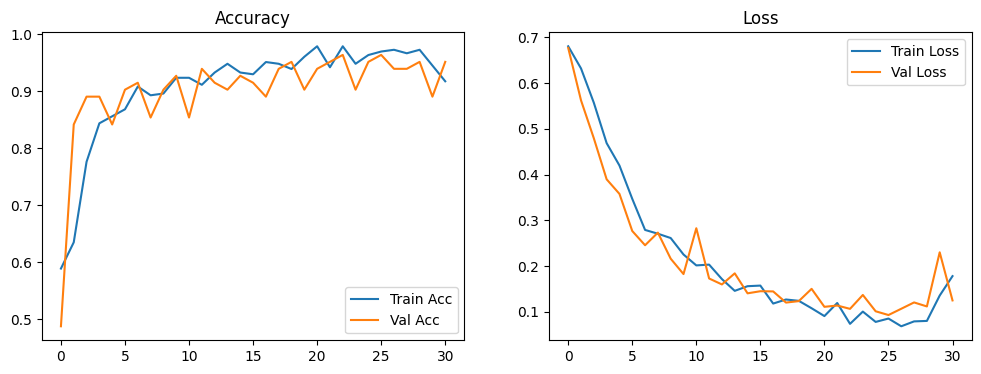

In [ ]:
# === Optional: Enable GPU memory growth ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# === Load VGGish ===
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

# === Extract VGGish Embeddings ===
def extract_vggish_embeddings(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        if len(audio) < int(sr * 0.96):
            raise ValueError("Audio too short for VGGish.")
        desired_len = sr * 10
        if len(audio) < desired_len:
            audio = np.pad(audio, (0, desired_len - len(audio)), mode='constant')
        else:
            audio = audio[:desired_len]
        audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
        embeddings = vggish_model(audio_tensor)
        return np.mean(embeddings.numpy(), axis=0)
    except Exception as e:
        raise RuntimeError(f"Failed to process {file_path}: {e}")

# === Load Dataset ===
data_dir = "/content/drive/MyDrive/Colab Notebooks/Laptop_Augumented_Dataset"
X, y = [], []

print("Extracting embeddings...")
for label in tqdm(os.listdir(data_dir)):
    label_path = os.path.join(data_dir, label)
    if not os.path.isdir(label_path): continue
    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)
        try:
            emb = extract_vggish_embeddings(file_path)
            if not np.isnan(emb).any():
                X.append(emb)
                y.append(label)
        except Exception as e:
            print(e)

# === Encode Labels ===
X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Save label encoder for future decoding
label_encoder_path = "/content/drive/MyDrive/Colab Notebooks/trained_models/label_encoder_510.pkl"
joblib.dump(le, label_encoder_path)

# === Split Data ===
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# === Classifier Model ===
model = Sequential([
    Dense(128, activation='relu', input_shape=(128,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# === Callbacks ===
model_path = "/content/drive/MyDrive/Colab Notebooks/trained_models/laptop_vggish_trained_model_510data.keras"
checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === Train Model ===
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, checkpoint])

# === Evaluate Model ===
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# === Plot Training ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


## Model Analysis

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


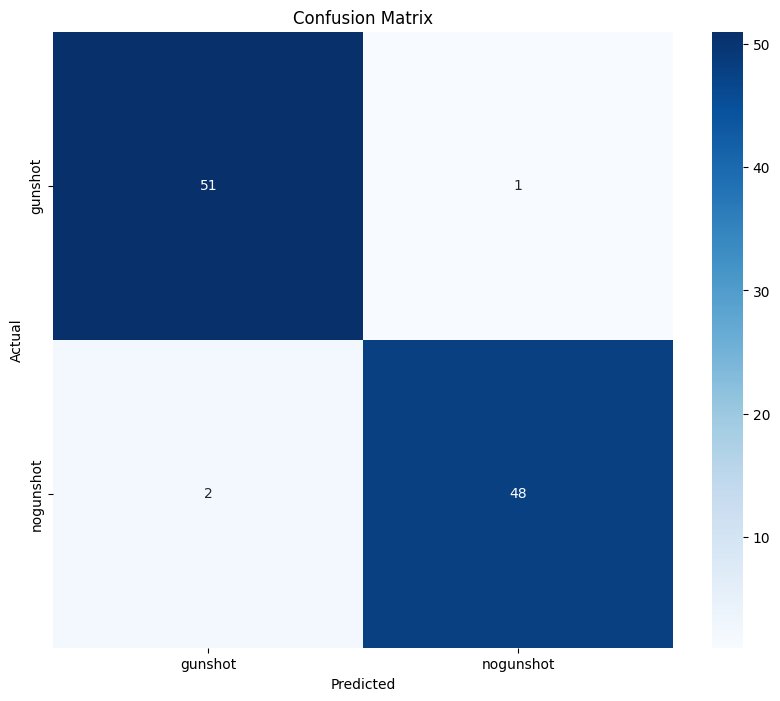

Classification Report:
               precision    recall  f1-score   support

     gunshot       0.96      0.98      0.97        52
   nogunshot       0.98      0.96      0.97        50

    accuracy                           0.97       102
   macro avg       0.97      0.97      0.97       102
weighted avg       0.97      0.97      0.97       102

Final Test Accuracy: 0.9706


In [ ]:
# === Predict and Decode ===
y_test_labels = np.argmax(y_test, axis=1)
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# === Confusion Matrix ===
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# === Classification Report ===
report = classification_report(y_test_labels, y_pred_labels, target_names=le.classes_)
print("Classification Report:\n", report)

# === Accuracy Score ===
test_acc = accuracy_score(y_test_labels, y_pred_labels)
print(f"Final Test Accuracy: {test_acc:.4f}")


## Model Testing

In [ ]:
label_encoder_path = "/content/drive/MyDrive/Colab Notebooks/trained_models/label_encoder_510.pkl"
model_path = "/content/drive/MyDrive/Colab Notebooks/trained_models/laptop_vggish_trained_model_510data.keras"

# === Load Required ===
from tensorflow.keras.models import load_model

# === Load Model and Label Encoder ===
model = tf.keras.models.load_model(model_path)
le = joblib.load(label_encoder_path)

# === Extract VGGish Embeddings ===
def extract_vggish_embeddings(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        if len(audio) < int(sr * 0.96):
            raise ValueError("Audio too short for VGGish.")
        desired_len = sr * 10
        if len(audio) < desired_len:
            audio = np.pad(audio, (0, desired_len - len(audio)), mode='constant')
        else:
            audio = audio[:desired_len]
        audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
        embeddings = vggish_model(audio_tensor)
        return np.mean(embeddings.numpy(), axis=0)
    except Exception as e:
        raise RuntimeError(f"Failed to process {file_path}: {e}")

# === Load VGGish ===
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

# === Prediction Function ===
def predict_audio_file(file_path):
    try:
        embedding = extract_vggish_embeddings(file_path)
        embedding = np.expand_dims(embedding, axis=0)  # shape: (1, 128)
        prediction = model.predict(embedding)
        predicted_index = np.argmax(prediction)
        predicted_label = le.inverse_transform([predicted_index])[0]
        print(f"Predicted Label: {predicted_label}")
        return predicted_label
    except Exception as e:
        print(f"Error: {e}")

# === Example Usage ===
predict_audio_file("/content/drive/MyDrive/Colab Notebooks/test_samples/test_101_mic1_filtered.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predicted Label: nogunshot


np.str_('nogunshot')